# Рекуррентные сети в Pytorch

# Подготовка среды

In [1]:
!pip install portalocker

In [2]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam

import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Подгрузка данных

In [4]:
train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()

In [5]:
target_classes = ["World", "Sports", "Business", "Sci/Tech"]

# Препроцессинг

## Токенизация

In [6]:
tokenizer = get_tokenizer("basic_english")

## Создание словаря

In [7]:
def build_vocabulary(dataset):
    for _, text in dataset:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    build_vocabulary(train_dataset),
    min_freq=1,
    specials=["<UNK>"]
)

vocab.set_default_index(vocab["<UNK>"])

len(vocab)

95811

In [8]:
vocab["<UNK>"]

0

In [9]:
vocab(['Kolbasa'])

[0]

## Создание Dataset, Dataloader

In [10]:
train_dataset, test_dataset  = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [11]:
y, x = train_dataset[0]

print('text:', x)
print('label:', y)

text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
label: 3


In [12]:
y, x = train_dataset[-1]

print('text:', x)
print('label:', y)

text: Nets get Carter from Raptors INDIANAPOLIS -- All-Star Vince Carter was traded by the Toronto Raptors to the New Jersey Nets for Alonzo Mourning, Eric Williams, Aaron Williams, and a pair of first-round draft picks yesterday.
label: 2


In [13]:
max_words = 25

def add_padding(tokens):
    if len(tokens) < max_words:
        n_pad_tokens = max_words - len(tokens)
        return tokens + ([0] * n_pad_tokens)
    else:
        return tokens[:max_words]


def vectorize_batch(batch):
    y, X = list(zip(*batch)) # разбиваем батч на X и Y

    X = [vocab(tokenizer(text)) for text in X] ## Токенизация и кодирование
    X = [add_padding(tokens) for tokens in X] # приводим батч к единому размеру

    y_tensor = torch.tensor(y) - 1
    X_tensor = torch.tensor(X, dtype=torch.int32)

    return X_tensor, y_tensor

In [14]:
batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=batch_size, collate_fn=vectorize_batch)

In [15]:
X_sample, y_sample = next(iter(train_loader))
X_sample.shape, y_sample.shape

(torch.Size([512, 25]), torch.Size([512]))

In [16]:
print(X_sample[0])

tensor([ 8122,    38,  1586,     3,  1050, 13540,     4,  2970,  3697,     2,
           88,   159,     8,     2,   168,   278,   189,    40,   555,    38,
          771,  3897,     4,     2,    50], dtype=torch.int32)


In [17]:
print(y_sample[0])

tensor(2)


# Обучение модели

## Полезные функции

In [18]:
def train_step(model, criterion, optimizer, dataloader):
    y_true, y_preds, losses = [], [], []
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        y_pred = model(X) # делаем предсказание
        loss = criterion(y_pred, y) # рассчитаем Loss
        loss.backward() ## рассчитываем градиент

        optimizer.step() ## меняем веса модели
        optimizer.zero_grad() # обнуляем градиент оптимизатора

        losses.append(loss.detach().cpu().item())
        y_true.append(y)
        y_preds.append(y_pred.argmax(dim=-1))

    y_true = torch.cat(y_true).detach().cpu().numpy()
    y_preds = torch.cat(y_preds).detach().cpu().numpy()

    loss_mean = torch.tensor(losses).mean()
    metric = accuracy_score(y_true, y_preds)

    return loss_mean, metric

def valid_step(model, criterion, dataloader):
    with torch.no_grad():
        y_true, y_preds, losses = [], [], []
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            y_pred = model(X)
            loss = criterion(y_pred, y)
            losses.append(loss.detach().cpu().item())

            y_true.append(y)
            y_preds.append(y_pred.argmax(dim=-1))

        y_true = torch.cat(y_true).detach().cpu().numpy()
        y_preds = torch.cat(y_preds).detach().cpu().numpy()

        loss_mean = torch.tensor(losses).mean()
        metric = accuracy_score(y_true, y_preds)

        return loss_mean, metric

def train_procedure(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    train_losses, train_metrics, valid_losses, valid_metrics = [], [], [], []
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss, train_metric = train_step(model, criterion, optimizer, train_loader)
        valid_loss, valid_metric = valid_step(model, criterion, val_loader)

        print("Epoch: {}".format(epoch))
        print("Train Loss : {:.3f}".format(train_loss))
        print("Train Acc  : {:.3f}".format(train_metric))
        print("Val Loss : {:.3f}".format(valid_loss))
        print("Val Acc  : {:.3f}".format(valid_metric))

        train_losses.append(train_loss)
        train_metrics.append(train_metric)
        valid_losses.append(valid_loss)
        valid_metrics.append(valid_metric)
    return train_losses, train_metrics, valid_losses, valid_metrics


In [19]:
def draw_plots(train_losses, train_metrics, valid_losses, valid_metrics):
    epoches = torch.arange(len(train_losses)) + 1
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epoches, train_losses, label='train_loss', marker='o')
    plt.plot(epoches, valid_losses, label='valid_loss', marker='v')
    plt.legend()
    plt.xlabel('эпохи')
    plt.ylabel('loss')
    plt.grid()


    plt.subplot(1, 2, 2)
    plt.plot(epoches, train_metrics, label='train_accuracy', marker='o')
    plt.plot(epoches, valid_metrics, label='valid_accuracy', marker='v')
    plt.legend()
    plt.xlabel('эпохи')
    plt.ylabel('accuracy')
    plt.grid()

    plt.show()

## RNN

In [20]:
class RNN(nn.Module):
    def __init__(self, vocab_size, n_classes, embed_size=64, hidden_dim=64):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim

        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, n_classes)

    def init_hidden_state(self, batch_size, device):
        h = torch.randn(1, batch_size, self.hidden_dim).to(device)
        return h

    def forward(self, X_batch):

        embeddings = self.embedding_layer(X_batch)
        device = X_batch.device
        h = self.init_hidden_state(batch_size=len(X_batch), device=device)
        output, h = self.rnn(embeddings, h)
        predict = self.linear(h.squeeze(0))
        return predict

In [21]:
rnn_model = RNN(vocab_size=len(vocab), n_classes=4)
rnn_model = rnn_model.to(device)
rnn_model

RNN(
  (embedding_layer): Embedding(95811, 64)
  (rnn): RNN(64, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=4, bias=True)
)

In [22]:
epochs = 4
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = Adam(rnn_model.parameters(), lr=learning_rate)

logges = train_procedure(rnn_model, criterion, optimizer, train_loader, test_loader, epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1
Train Loss : 1.149
Train Acc  : 0.467
Val Loss : 0.821
Val Acc  : 0.670
Epoch: 2
Train Loss : 0.662
Train Acc  : 0.750
Val Loss : 0.577
Val Acc  : 0.788
Epoch: 3
Train Loss : 0.489
Train Acc  : 0.827
Val Loss : 0.498
Val Acc  : 0.827
Epoch: 4
Train Loss : 0.408
Train Acc  : 0.861
Val Loss : 0.440
Val Acc  : 0.850


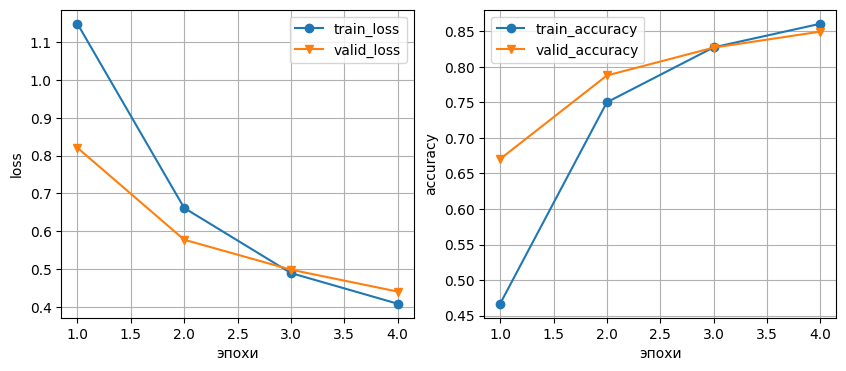

In [23]:
train_losses, train_metrics, valid_losses, valid_metrics = logges
draw_plots(train_losses, train_metrics, valid_losses, valid_metrics)

## LSTM

In [24]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, n_classes, embed_size=64, hidden_dim=64):
        super(LSTM, self).__init__()

        self.hidden_dim = hidden_dim

        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, n_classes)

    def init_hidden_state(self, batch_size, device):
        h = torch.randn(1, batch_size, self.hidden_dim).to(device)
        c = torch.randn(1, batch_size, self.hidden_dim).to(device)
        return h, c

    def forward(self, X_batch):

        embeddings = self.embedding_layer(X_batch)
        device = X_batch.device
        h, c = self.init_hidden_state(batch_size=len(X_batch), device=device)
        output, (h, c) = self.lstm(embeddings, (h, c))
        predict = self.linear(h.squeeze(0))
        return predict

In [25]:
lstm_model = LSTM(vocab_size=len(vocab), n_classes=4)
lstm_model = lstm_model.to(device)
lstm_model

LSTM(
  (embedding_layer): Embedding(95811, 64)
  (lstm): LSTM(64, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=4, bias=True)
)

In [26]:
epochs = 4
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = Adam(lstm_model.parameters(), lr=learning_rate)

logges = train_procedure(lstm_model, criterion, optimizer, train_loader, test_loader, epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1
Train Loss : 0.991
Train Acc  : 0.567
Val Loss : 0.623
Val Acc  : 0.768
Epoch: 2
Train Loss : 0.500
Train Acc  : 0.819
Val Loss : 0.463
Val Acc  : 0.838
Epoch: 3
Train Loss : 0.379
Train Acc  : 0.867
Val Loss : 0.419
Val Acc  : 0.850
Epoch: 4
Train Loss : 0.317
Train Acc  : 0.890
Val Loss : 0.379
Val Acc  : 0.867


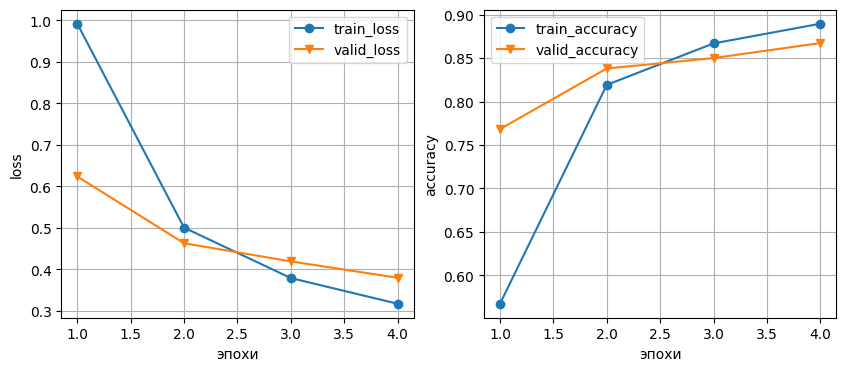

In [27]:
train_losses, train_metrics, valid_losses, valid_metrics = logges
draw_plots(train_losses, train_metrics, valid_losses, valid_metrics)

## BiLSTM

In [28]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, n_classes, embed_size=64, hidden_dim=64):
        super(BiLSTM, self).__init__()

        self.hidden_dim = hidden_dim

        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_dim * 2, n_classes)

    def init_hidden_state(self, batch_size, device):
        h = torch.randn(2, batch_size, self.hidden_dim).to(device)
        c = torch.randn(2, batch_size, self.hidden_dim).to(device)
        return h, c

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        device = X_batch.device
        h, c = self.init_hidden_state(batch_size=len(X_batch), device=device)
        output, (h, c) = self.lstm(embeddings, (h, c))
        linear_in = h.transpose(0, 1).reshape(len(X_batch), 2 * self.hidden_dim)
        predict = self.linear(linear_in)
        return predict

In [29]:
bilstm_model = BiLSTM(vocab_size=len(vocab), n_classes=4)
bilstm_model = bilstm_model.to(device)
bilstm_model

BiLSTM(
  (embedding_layer): Embedding(95811, 64)
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=4, bias=True)
)

In [30]:
epochs = 4
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = Adam(bilstm_model.parameters(), lr=learning_rate)

logges = train_procedure(bilstm_model, criterion, optimizer, train_loader, test_loader, epochs)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1
Train Loss : 0.905
Train Acc  : 0.622
Val Loss : 0.547
Val Acc  : 0.799
Epoch: 2
Train Loss : 0.440
Train Acc  : 0.842
Val Loss : 0.405
Val Acc  : 0.859
Epoch: 3
Train Loss : 0.331
Train Acc  : 0.883
Val Loss : 0.359
Val Acc  : 0.872
Epoch: 4
Train Loss : 0.270
Train Acc  : 0.906
Val Loss : 0.341
Val Acc  : 0.880


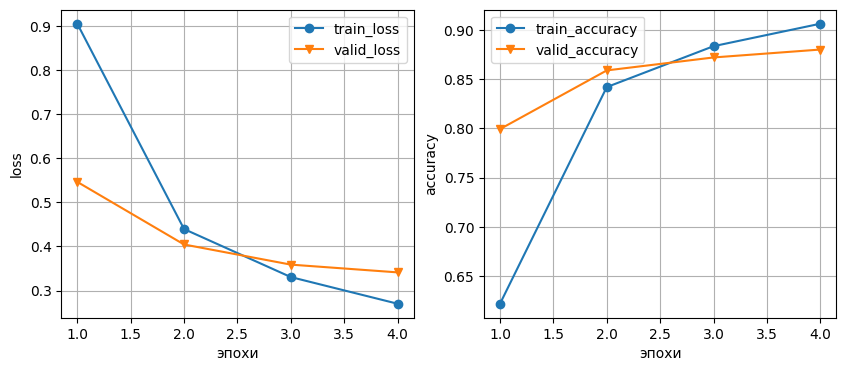

In [31]:
train_losses, train_metrics, valid_losses, valid_metrics = logges
draw_plots(train_losses, train_metrics, valid_losses, valid_metrics)